<a href="https://colab.research.google.com/github/gbrunkhorst/Lead210_Sed_Bayes/blob/main/Lead210_Bayes_2021_07_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lead 210 Sediment Profile Modeling Using the Bayesian Workflow in Python

Greg Brunkhorst 7/27/2021


# Outline

This notebook presents a Bayesian workflow approach to modeling excess lead 210 in sediment.  This is intended as an introduction to Bayesian tools for environmental scientists, or an interesting use case for Bayesian practitioners.  This notebook has the following parts: 
1. Bayesian Work Flow
2. Lead210 Model
3. Generate Data
4. Specify Pymc3 Model
5. Prior Predictive Checks
6. Bayesian Inference
7. Posterior Predictive Checks
8. Uncertainty
9. Extensions

# Bayesian Work Flow
First a quick note on the Bayesian work flow.  A reason that Bayesian statistics are intuitive for scientists is that statistical models are developed as generative models.  Since environmental scientists naturally think in terms of generative physical models, these are easily translated into the Bayesian workflow.  The general Bayesian workflow used in this notebook is the following: 
1. Identify the data generating process.  In our case, we will use a physical model from literature, generate data, and specify the model equations in the pymc3 model.  
2. Identify priors for unknowm parameters.  We will use weakly informative priors that are consistent with the physical processes we are modeling.  
3. Perform Bayesian inference on unknown model parameters given the data.  
4. Assess the model inference and perform posterior predictive checks.  
5. Iterate and modify as needed.  

## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm 
import arviz as az
import theano.tensor as tt
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [8.0, 6.0]

# Lead 210 Model
## Lead 210 in Sediments
Lead 210 is a naturally occuring radioactive isotope with a half-life of 22.3 years that is the degradation product of atmospheric radon 222.  Atmospheric lead 210 binds to particulate matter and is deposited in sedimentary layers.  As sediment accumulates (e.g., on the seafloor), lead 210 decays at a constant rate, resulting in an exponential decay curve of lead 210 activity with sediment depth.  In areas with higher deposition rates, sediment is younger at depth, resulting in a lead 210 activity curve that is flatter (i.e., more activity at a given depth due to younger sediment).  In areas with lower deposition rates, sediment is older at depth and the lead 210 activity curve is steeper (i.e., less activity at a given depth).  

Another source of lead 210, referred to as supported lead 210, comes from the surrounding geology rather than the atmosphere.  Supported lead 210 is subtracted from total lead 210 to calculate excess lead 210.  This notebook assumes that supported lead 210 has already been subtracted out prior to analysis.  

One other confounding factor is that surface sediments (e.g., the upper 5-10 cm of sediments) tend to mix due to physical factors (e.g., bioturbation), which results in a flatter exponential decay function in near-surface sediments.  

The purpose of this analysis is to infer the lead210 loading rate, sediment deposition rate,  sediment mixing rate, and sediment mixing depth based on core profiles (lead210 activity with depth).  Infering these parameters has many applications in sediment science, for example understanding the fate and transport of contaminants that may have also been deposited in sediments.  



## Abril Model
We will implement an analytical model developed by JM Abril in [Analytical solutions of the tracer-conservation equation in sediments, reviewed from the compaction potential theory: A unifying approach for radiometric dating models](https://www.researchgate.net/publication/266279845_Analytical_solutions_of_the_tracer-conservation_equation_in_sediments_reviewed_from_the_com-_paction_potential_theory_A_unifying_approach_for_radiometric_dating_models).  This analytical model equation is shown below:  

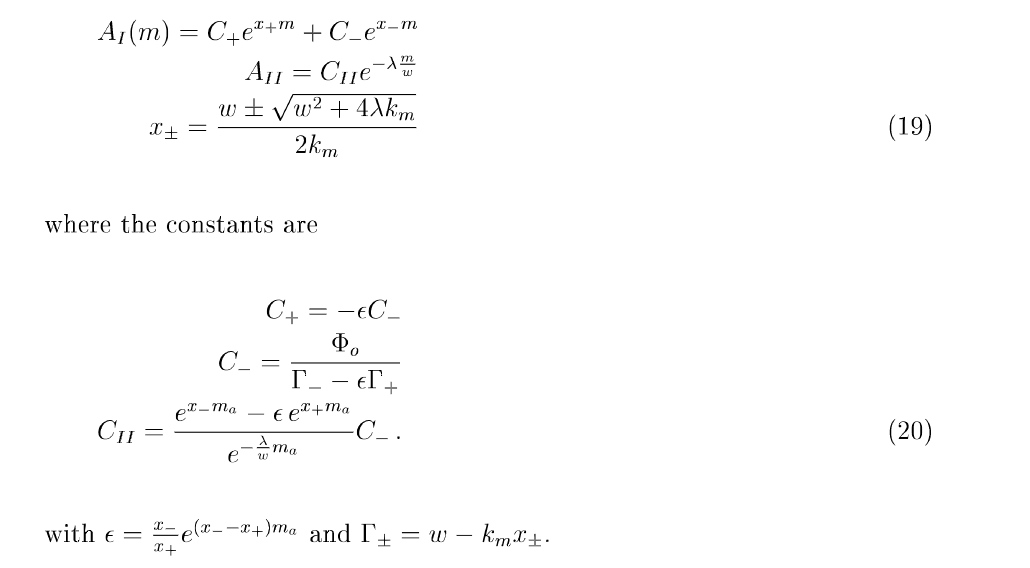

where: 
* A(m) is the lead210 activity with depth (dpm/g)
* m is the mass-depth of sediment (i.e., density-corrected depth) (g/cm2/yr)
* phi is the lead210 loading rate (dpm/cm2/yr)
* w is the deposition rate (g/cm2/yr)
* ma is the depth of mixing (g/cm2)
* km is the coeefficient of mixing (g2/cm4/yr)
* lam is the decay rate (1/yr)

## Numpy Implementation of the Abril Model
Model function  

In [ ]:
def A_calc(m,                       # g/cm2
            w = 0.1,                # g/cm2/yr
            Phi = 10,               # dpm/cm2/yr
            ma = 5,                 # g/cm2
            km = 0.5,               # g2/cm4/yr
            lam = np.log(2)/22.3):  # yr
    '''Calculate coefficients for the model'''
             
    xp = (w + (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    xm = (w - (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    eps = xm/xp*np.exp((xm-xp)*ma)
    Gamp = w - km * xp
    Gamm = w - km * xm
    Cm = Phi / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (np.exp(xm*ma) - eps * np.exp(xp * ma) ) * Cm / np.exp(-lam*ma/w)
    if m < ma:
        return Cp  * np.exp(xp * m) + Cm * np.exp(xm * m)
    if m >= ma:
        return CII * np.exp(-lam*m/w)

Vectorize the fuction

In [ ]:
vect_A_calc = np.vectorize(A_calc)

## Plot
Plot the four example curves from the paper.  

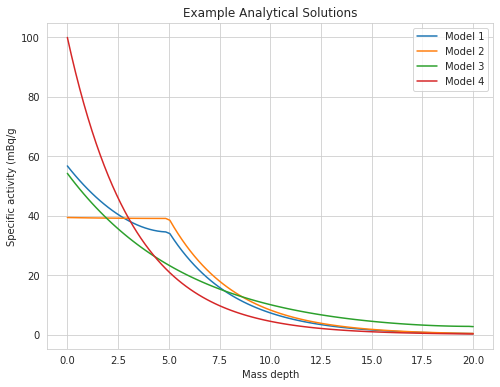

In [ ]:
ws = [.1]*4
phis = [10.]*4
kms = [.5, 50., 0.5, 1e-8]
mas = [5, 5, 19.9, 0]
lam = np.log(2)/22.3
i = 0
mass_depth = np.linspace(0,20,100)  # set up the mass depth array
for i in range(len(ws)):  
    At = vect_A_calc(mass_depth, ws[i], phis[i], mas[i], kms[i])
    plt.plot(mass_depth,At, label='Model '+str(i+1))
    i+=1
plt.legend()
plt.xlabel("Mass depth")
plt.ylabel("Specific activity (mBq/g")
plt.title("Example Analytical Solutions");

Compares well to the Abril Paper:  

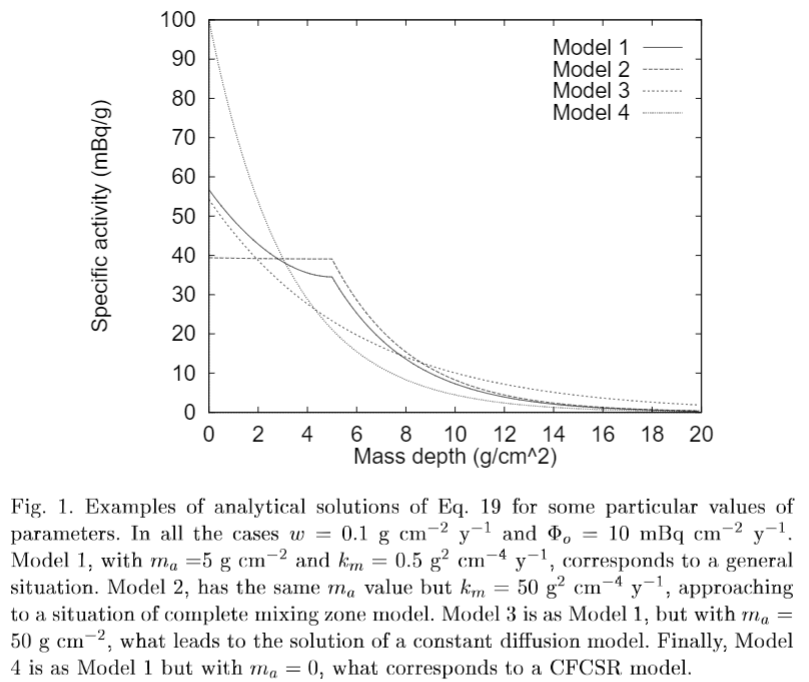

# Generate Data
Let's generate data to fit to the model.  Use the parameters from model 0 above.  Assume one sample every 2 cm.  

In [ ]:
i = 0
mass_depth = np.linspace(0,20,20)  # set up the mass depth array
At = vect_A_calc(mass_depth, ws[i], phis[i], mas[i], kms[i])

Text(0.5, 1.0, 'Underlying Model Parameters and Generated Noisey Data')

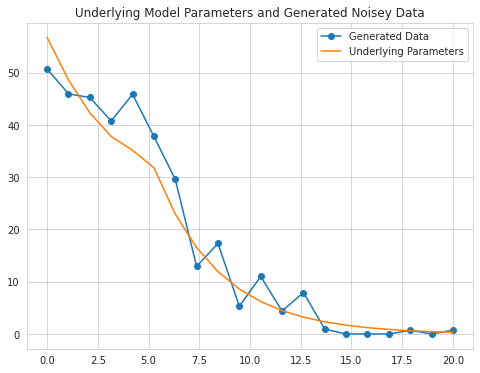

In [ ]:
# add noise - environmental data can be quite noisey, especially with mixing
# I plan to discuss heteroskedastic error later
At_data = At + np.random.normal(scale=5, size = len(mass_depth))
# keep non-negative
At_data = np.where(At_data<0,0,At_data)
plt.plot(mass_depth, At_data, 'o-', label = 'Generated Data')
plt.plot(mass_depth, At , label = 'Underlying Parameters')
plt.legend()
plt.title('Underlying Model Parameters and Generated Noisey Data')

# Specify Pymc3 Model
We rewrite the numpy model in pymc3.  The pymc3 model includes: 
1. data
2. priors on inferred parameters
3. model equations
4. observed data error model and likelihood calculation

In [ ]:
with pm.Model() as model:
    # Save data in the model for access later
    At_data_model = pm.Data("At_data", At_data)
    mass_depth_model = pm.Data("mass_depth", mass_depth)

    # Weakly informative priors.  We know from our knowledge
    # of the physical system what reasonable bounds we might have
    Bounded_w = pm.Bound(pm.Gamma, lower=0.01, upper=1)
    w = Bounded_w('w', mu = 0.1, sigma = 0.1/2 )            # g/cm2/yr
    Phi = pm.Gamma('Phi', mu = 10, sigma = 10/2)            # dpm/cm2/yr
    Bounded_ma = pm.Bound(pm.Normal, lower=0, upper=20)
    ma = Bounded_ma('ma', mu = 5, sigma = 5)              # g/cm2
    Bounded_km = pm.Bound(pm.Normal, lower=0, upper=20)
    km = Bounded_km('km', mu = 10, sigma = 10/2)             # g2/cm4/yr

    # Analytical model equations - same as the numpy implementation above
    # must used pm functions rather than np functions
    xp = (w + (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    xm = (w - (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    eps = xm / xp * pm.math.exp((xm-xp)*ma)
    Gamp = w - km * xp
    Gamm = w - km * xm
    Cm = Phi / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (pm.math.exp(xm * ma) - eps * pm.math.exp(xp * ma) ) * Cm / pm.math.exp(-lam  * ma / w)
    # Ct is the prediction 
    # pm.math.switch performs the if statment function
    Ct =  rate = pm.math.switch(ma > mass_depth_model,
        Cp  * pm.math.exp(xp * mass_depth_model) + Cm * pm.math.exp(xm * mass_depth_model),
        CII * pm.math.exp(-lam * mass_depth_model / w))

    # set a positive sd around the prediction
    sigma = pm.HalfNormal('sigma', sigma=10)  
    # Likelihood (sampling distribution) of observations
    At_pred = pm.Normal('At_pred', mu=Ct, sigma=sigma, observed=At_data_model)


# Prior Predictive Check

In [ ]:
sams = 50
pp = pm.sample_prior_predictive(samples=sams, model=model)
pp;

## Plot

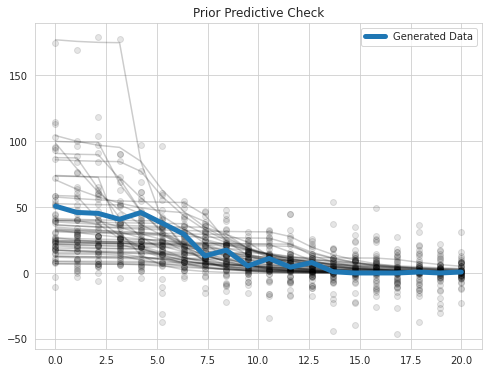

In [ ]:
mass_depth = np.linspace(0,20,20) 
for i in range(sams):
    At_vals = pp['At_pred'][i]
    At = vect_A_calc(mass_depth, pp['w'][i], pp['Phi'][i], pp['ma'][i], pp['km'][i])
    plt.plot(mass_depth, At, color = 'black', alpha=.2)
    plt.plot(mass_depth, At_vals,'o', color = 'black', alpha=.1)
plt.plot(mass_depth, At_data, label = 'Generated Data', lw=5)
plt.legend()
plt.title('Prior Predictive Check');

The priors generally surround the observed data.  Visually, this indicates a weakly informative priors.  Note that data can go negative.  This can be adjusted with the error model (e.g., using a gamma distribution for the error model), but for this purpose, we will allow posterior predictive values to be negative.  

# Inference

In [ ]:
with model:
    trace = pm.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, km, ma, Phi, w]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


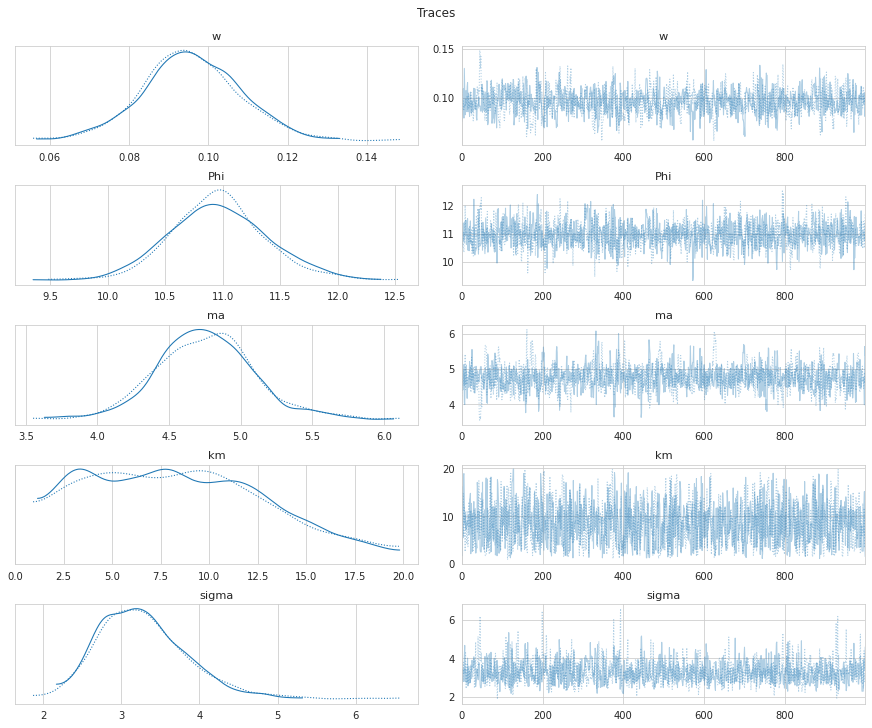

In [ ]:
az.plot_trace(trace)
plt.suptitle('Traces');

# Posterior

In [ ]:
summary = az.summary(trace)
summary

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w,0.096,0.013,0.074,0.121,0.000,0.000,873.0,862.0,1.0
Phi,10.963,0.428,10.101,11.739,0.012,0.008,1376.0,951.0,1.0
ma,4.757,0.354,4.109,5.472,0.013,0.009,854.0,741.0,1.0
km,8.474,4.411,1.172,16.026,0.112,0.082,1503.0,1124.0,1.0
sigma,3.287,0.589,2.232,4.310,0.017,0.012,1321.0,1125.0,1.0


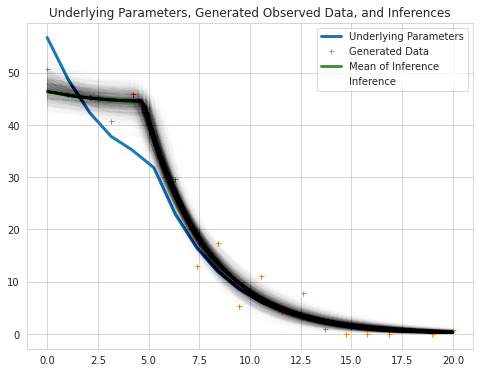

In [ ]:
mass_depth_model = np.linspace(0,20,100)
mass_depth_sample = np.linspace(0,20,20)
# Underlying parameters
i=0
At = vect_A_calc(mass_depth_sample, ws[i], phis[i], mas[i], kms[i])
plt.plot(mass_depth_sample, At , label = 'Underlying Parameters', lw=3)
# Plot the "observed" data
plt.plot(mass_depth_sample, At_data, "+", label = 'Generated Data',markersize=5)
# Plot the mean of the posterior inferences
At = vect_A_calc(mass_depth_model, summary.at['w','mean'], summary.at['Phi','mean'], 
                 summary.at['ma','mean'], summary.at['km','mean'])
plt.plot(mass_depth_model, At , label = 'Mean of Inference', lw=3)
# plot the inference instances
for i in range(trace['w'].shape[0]):
    At = vect_A_calc(mass_depth_model, trace['w'][i], trace['Phi'][i], trace['ma'][i], trace['km'][i])
    if i==0:
        plt.plot(mass_depth_model, At, color = 'black', alpha=.003, label="Inference")
    else:
        plt.plot(mass_depth_model, At, color = 'black', alpha=.003)
plt.legend()
plt.title('Underlying Parameters, Generated Observed Data, and Inferences');

There are different parameter values that can reasonably fit the data. Bayesian inference provides reasonable best estimates and ranges around the best estimate.  Noise has a large effect on the range of inference data.  

# Posterior Predictive
The posterior predictive provides information on the posterior model fit that includes the error model (i.e., the scatter around the model curves).  

In [ ]:
sams = 100
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=sams)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


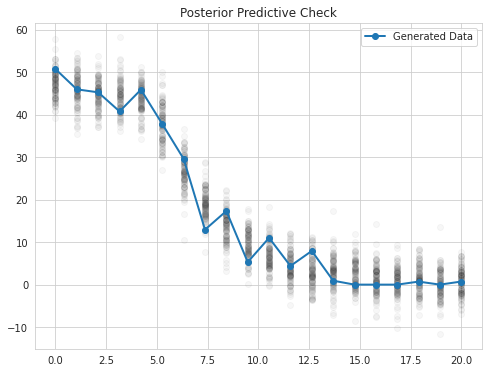

In [ ]:
mass_depth = np.linspace(0,20,20) 
for i in range(sams):
    At_vals = ppc['At_pred'][i]
    plt.plot(mass_depth, At_vals,'o', color = 'black', alpha=.03)
plt.plot(mass_depth, At_data,'o-', label = 'Generated Data', lw=2)
plt.legend()
plt.title('Posterior Predictive Check');

Posterior predictive values generally envelop the data with a reasonal scatter.  Negative values are not realistic - this can be modified by altering the error model.  

# Uncertainty
Finally, let's analyze the parameters, which have some interesting coorelations and local maxima.  These make physical sense given the model (e.g., as mixing depth goes up, deposition must go down to maintain a model fit.  

In [ ]:
az.plot_pair(trace, var_names = ['Phi','w','ma', 'km'],
             kind=["scatter", "kde"],
              point_estimate="median",
              figsize=(10, 8))
plt.suptitle("Parameter Coorelations and Uncertainty in Inferred Model Parameters", size = 16);

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


# Extensions
This notebook provides a full Bayesian workflow for fitting generated "observed" data to a lead 210 model.  The example model provides a reasonable fit and measurement of uncertainty in fitting the generated data.  There are ways to improve the Bayesian approach to this model.  Here is some low-hanging fruit with respect to inproving this implementation:

**Hierarchical model for multiple cores**.  Multiple cores can be fit simultaneous with adaptive priors in the hierarchical model format.  This can help to constrain parameters during model fitting.    

**Improved error modeling**.  Predicted values can be constrained to positive values by implementing a gamma distribution error model around mean model-predicted values.  This will result in skewed error distributions around the mean value.  I do not recommend using log-normal distributions for error modeling, as they have lead to unreasonable results on the high end (i.e., too skewed) in my experience.  The truncated normal distribution does not appear to work for posterior distributions in pymc3, and I have found the pm.potential function very difficult to use.  I have found heteroskedastic models to be very easy to implement and effective at fitting real data (e.g., specify the variance term to be proportional to the mean).

**Incorporating additional geochemical information**.  Other geochemical information can be used to constrain the lead210 curve fit.  For example, I have experimented with including a plutonium isotope term, where the depth to non-detected plutonium equals the depth of mixing plus the deposition times the duration since 1945. 

**Alternative analytical model specifications**.  In this context, analytical model specifications are simple to implement.  The function pm.switch() could be used in different applications, e.g., changes in deposition rates over time.   